# Lecture 16 — Logistic Regression, Support Vector Machines

# Preliminaries

We will demonstrate the concepts of this lecture on the classic `iris` dataset, which has three classes and four features.

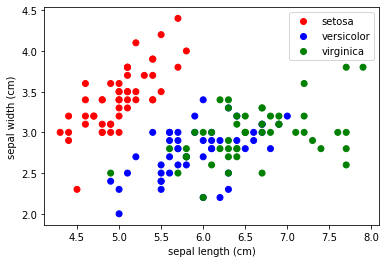

In [1]:
# Load `iris` dataset.
from sklearn.datasets import load_iris
iris = load_iris()
classes = list(iris.target_names)
features = iris.feature_names
X = iris.data
Y = iris.target
# Plot two features.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'blue', 'green'])
scatter = plt.scatter(X[:,0], X[:,1], c=Y, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

At times we may wish to divide the data into two classes, for example:

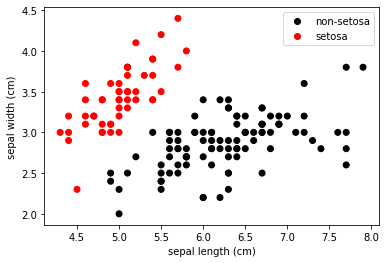

In [2]:
# Divide data into two classes.
import numpy as np
Y_setosa = (Y == 0).astype(np.int64)
classes_setosa = ['non-setosa', 'setosa']
colors_setosa = ListedColormap(['black', 'red'])
# Plot the two-class division.
scatter = plt.scatter(X[:,0], X[:,1], c=Y_setosa, cmap=colors_setosa)
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

# Logistic Regression

To develop logistic regression, imagine trying to apply linear regression with class as a numeric target variable.  Below we show a plot of class against one feature for the `iris` dataset. Setosa is encoded as `1`, non-setosa as `0`.

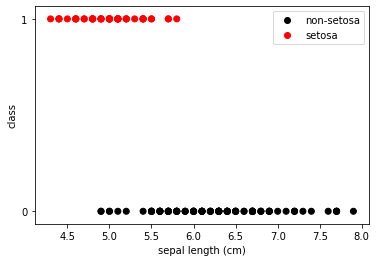

In [3]:
# Plot as if class were a numeric feature.
scatter = plt.scatter(X[:,0], Y_setosa, c=Y_setosa, cmap=colors_setosa)
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.xlabel(features[0])
plt.ylabel('class')
plt.yticks([0,1])
plt.show()

We perform linear regression of class on sepal length:

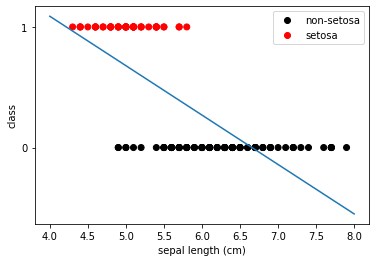

In [4]:
# Linear regression to predict class.
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X[:,0].reshape(-1,1), Y_setosa) # Reshape casts as nx1 array.
# Plot data.
scatter = plt.scatter(X[:,0], Y_setosa, c=Y_setosa, cmap=colors_setosa)
plt.xlabel(features[0])
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.ylabel('class')
plt.yticks([0, 1])
# Plot predictions.
xx = np.linspace(4, 8, 100)
yy = reg.predict(xx.reshape(-1,1))
plt.plot(xx, yy)
plt.show()

Our linear model does not just predict values 1 and 0. It also predicts values between 1 and 0. We might interpret the predictions as probabilities $p$ of belonging to class 1. 

We could form a classifier using the following rule: Let $T$ be a threshold. If the model outputs $p \geq T$ for input $x$, classify $x$ as belonging to class 1, else classify $x$ as belonging to class 0.

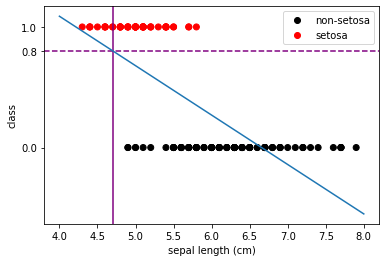

True Positive Rate: 0.22
False Positive Rate: 0.0
True Negative Rate: 1.0
False Negative Rate: 0.78
Overall Accuracy 0.74


In [5]:
# Threshold value.
thresh = 0.80
# Plot data.
scatter = plt.scatter(X[:,0], Y_setosa, c=Y_setosa, cmap=colors_setosa)
plt.xlabel(features[0])
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.ylabel('class')
plt.yticks([0, thresh, 1])
# Plot decision boundary by solving b0 + b1*x = thresh.
dbnd = (thresh - reg.intercept_) / reg.coef_[0]
plt.axvline(x=dbnd, color='purple')
plt.axhline(y=thresh, color='purple', linestyle='--')
plt.plot(xx, yy)
plt.show()
# Metrics.
print('True Positive Rate:', 
      np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) >= thresh) * (Y_setosa==1)
      ) / np.sum(Y_setosa==1)
)
print('False Positive Rate:', 
      np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) >= thresh) * (Y_setosa==0)
      ) / np.sum(Y_setosa==0)
)
print('True Negative Rate:', 
      np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) < thresh) * (Y_setosa==0)
      ) / np.sum(Y_setosa==0)
)
print('False Negative Rate:', 
      np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) < thresh) * (Y_setosa==1)
      ) / np.sum(Y_setosa==1)
)
print('Overall Accuracy', 
      (np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) >= thresh) * (Y_setosa==1)
      ) + \
      np.sum(
          (reg.predict(X[:,0].reshape(-1,1)) < thresh) * (Y_setosa==0)
      )) / len(Y_setosa)
)

The above model has disadvantages:

- Output can be above 1 and below 0, which is incompatible with the probability interpretation.
- It forces us into assuming the relation between the predictors and probabilitiy of class inclusion is linear. We may want a more flexible relation.

To overcome these disadvantages we can use a prediction function which is 
- Bounded between 1 and 0.
- More flexible than a hyperplane.

One popular choice is the _logistic function_:

$$\frac{\exp\left( \beta_{0} + \beta_{1:p}^{T}x \right)}{1 + \exp \left( \beta_{0} + \beta_{1:p}^{T}x \right)}$$

In two dimensions, $\beta_{0}$ determines the midpoint, and $\beta_{1}$ determines the curvature.

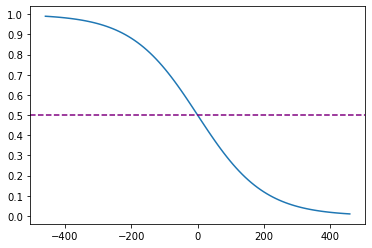

In [6]:
# 2D logistic function.
def logi2d(x, b0=0, b1=1):
    return np.exp(b0 + b1*x) / (1 + np.exp(b0 + b1*x))
# Parameters.
b0 = 0
b1 = -1/100
# Plot.
xx = np.linspace((np.log(1/99) - b0)/b1, (np.log(99/1) - b0)/b1, 100)
plt.plot(xx, logi2d(xx, b0, b1))
plt.axhline(y=0.50, color='purple', linestyle='--')
plt.yticks(np.linspace(0, 1, 11))
plt.show()

The logistic regression model with parameter $\beta$ for the probability $p(x; \beta)$ that $x$ is in class 1 is

$$p(x; \beta) =  \frac{\exp\left( \beta_{0} + \beta_{1:p}^{T}x \right)}{1 + \exp \left( \beta_{0} + \beta_{1:p}^{T}x \right)}$$

This is implemented in `sklearn.linear_model.LogisticRegression`.

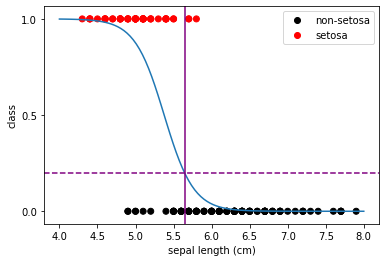

b0: 27.828522536436935
b1: -5.175698328318747


In [7]:
# Fit logistic regression without regularization.
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none').fit(
    X[:,0].reshape(-1,1), Y_setosa)
# Plot data.
thresh = 0.20 # For decision boundary.
scatter = plt.scatter(X[:,0], Y_setosa, c=Y_setosa, cmap=colors_setosa)
plt.xlabel(features[0])
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.ylabel('class')
plt.yticks([0, 0.50, 1])
xx = np.linspace(4, 8, 100)
# Output of fitted model.
yy = logi2d(xx, clf.intercept_, clf.coef_[0])
plt.plot(xx, yy)
# Decision boundary by solving b0 + b1*x = log(thresh/(1-thresh)).
dbnd = (np.log(thresh/(1-thresh)) - clf.intercept_) / clf.coef_[0]
plt.axvline(x=dbnd, color='purple')
plt.axhline(y=thresh, color='purple', linestyle='--')
plt.show()
# Print parameters.
print("b0:", clf.intercept_[0])
print("b1:", clf.coef_[0,0])

The logistic regression model is equivalent to

$$ \log \left( \frac{p(x; \beta)}{1-p(x; \beta)} \right) = \beta_{0} + \beta_{1:p}^{T}x$$

The expression on the left is the log odds of inclusion in class 1. Logistic regression models this log odds as a linear function. For $k \geq 1$, if $\beta_{k}$ of a model is positive, the model posits a positive relationship between variable $k$ and inclusion in class 1. If $\beta_{k}$ is negative, the model posits a negative relation.

The logistic regression model can be fit by the method of maximum likelihood. Find $\beta$ to maximize:

$$L\left(X,Y;\beta\right) = \prod_{i:y_{i}=1}p(x_{i};\beta) \prod_{i:y_{i}=0}\left(1 - p\left(x_{i};\beta\right)\right)$$

`sklearn` solves an equivalent problem by finding $\beta$ to minimize:

$$\sum_{i=1}^{n} \log \left( \exp \left( - y_{i} \left( \beta_{0} + \beta_{1:p}^{T}x_{i}\right) \right) + 1 \right)$$

where inclusion in class 1 is encoded as $y_{i} = 1$ and non-inclusion as $y_{i} = -1$. 

`sklearn` implements three forms of regularization. In $L2$ regularization, the objective function becomes:

$$ \frac{1}{2} \lVert \beta \rVert^{2}_{2} + C\sum_{i=1}^{n} \log \left( \exp \left( - y_{i} \left( \beta_{0} + \beta_{1:p}^{T}x_{i}\right) \right) + 1 \right)$$

Decreasing $C$ increases the relative force of the penalty term. Hence $C$ is called the _inverse regularization strength parameter_. 

The $L2$ penalty has the effect of shrinking the magnitude of parameter estimates. This can help to reduce overfitting.

In $L1$ regularization, the objective function becomes 

$$ \lVert \beta \rVert_{1} + C\sum_{i=1}^{n} \log \left( \exp \left( - y_{i} \left( \beta_{0} + \beta_{1:p}^{T}x_{i}\right) \right) + 1 \right)$$

The $L1$ penalty has the effect of allowing some parameters to be reduced to zero. $L1$ regularization can thus provide a form of variable selection. However, if a group of variables are correlated, the $L1$ penalty may shrink the corresponding parameter estimates too much.

A compromise between the two forms of regularization is _elastic-net regularization_, which has objective

$$ \rho \lVert \beta \rVert_{1} + (1-\rho)\left(\frac{1}{2} \lVert \beta \rVert^{2}_{2}\right) + C\sum_{i=1}^{n} \log \left( \exp \left( - y_{i} \left( \beta_{0} + \beta_{1:p}^{T}x_{i}\right) \right) + 1 \right)$$

Here $\rho$ controls the strength of the $L1$ vs. $L2$ regularization.

Always remember to perform a standard scaling of the features before performing regularization. The regularization is affected by the magnitude of parameter estimates, which is in turn affected by the magnitudes in your data.

A useful function for determining optimal regularization parameters through cross-validation is `sklearn.linear_model.LogisticRegressionCV`.

Putting everything together, we fit a logistic regression model in two dimensions using regularization.

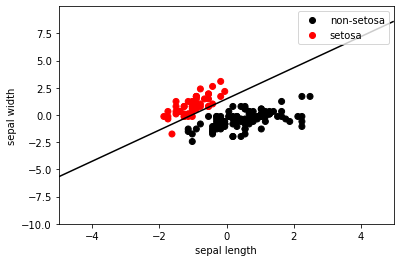

Regularization
b0: -1.5700753047570024
b1: -2.331003769537517
b2: 1.6308791526139377
Accuracy: 0.9933333333333333
True Positive Rate: 0.98
False Positive Rate: 0.0
True Negative Rate: 1.0
False Negative Rate: 0.02
Overall Accuracy 0.9933333333333333


In [8]:
# Scale data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Model with regularization.
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(
    cv=5, 
    random_state=0).fit(X[:,:2], Y_setosa)
# Plot.
scatter = plt.scatter(X[:,0], X[:,1], c=Y_setosa, cmap=colors_setosa)
plt.xlabel('sepal length')
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.ylabel('sepal width')
# Calculate predicted probabilities on a grid with prediction method.
thresh = 0.70
xx, yy = np.mgrid[-5:5:.01, -10:10:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape) 
plt.contour(xx, yy, probs, 
            levels=[thresh], cmap="Greys", vmin=0, vmax=.6)
plt.show()
# Print parameters.
print("Regularization")
print("b0:", clf.intercept_[0])
print("b1:", clf.coef_[0,0])
print("b2:", clf.coef_[0,1])
print("Accuracy:", np.mean(clf.predict(X[:,:2]) == Y_setosa))
# Metrics.
print('True Positive Rate:', 
      np.sum(
          (clf.predict(X[:,:2]) >= thresh) * (Y_setosa==1)
      ) / np.sum(Y_setosa==1)
)
print('False Positive Rate:', 
      np.sum(
          (clf.predict(X[:,:2]) >= thresh) * (Y_setosa==0)
      ) / np.sum(Y_setosa==0)
)
print('True Negative Rate:', 
      np.sum(
          (clf.predict(X[:,:2]) < thresh) * (Y_setosa==0)
      ) / np.sum(Y_setosa==0)
)
print('False Negative Rate:', 
      np.sum(
          (clf.predict(X[:,:2]) < thresh) * (Y_setosa==1)
      ) / np.sum(Y_setosa==1)
)
print('Overall Accuracy', 
      (np.sum(
          (clf.predict(X[:,:2]) >= thresh) * (Y_setosa==1)
      ) + \
      np.sum(
          (clf.predict(X[:,:2]) < thresh) * (Y_setosa==0)
      )) / len(Y_setosa)
)

We have discussed the logistic regression model for binary classification. To use logistic regression for multiple classes, we can employ several strategies:
- _One-vs-Rest._ Fit $K$ binary classifiers for $K$ classes. Classify an instance based on which class is assigned the highest probability. Implemented in `sklearn`'s logistic regression.
- _One-vs-One._ Fit $\binom{K}{2}$ binary classifiers comparing all classes against each other.
- _Multinomial Logistic Regression._ Model log odds of classes against each other. Implemented in `sklearn`'s logistic regression. Requires fitting parameter sets $\beta^{(k)}$ for $k=1, \ldots, K$: 

$$\log \left( \frac{P(Y=k|X=x)}{P(Y=K|X=x)} \right) =(\beta^{(k)}_{0} - \beta^{(K)}_{0}) + (\beta^{(k)}_{1:p} - \beta^{(K)}_{1:p})^{T}x$$ 



### Exercise
Fit a logistic regression model which takes sepal length and sepal width as input and gives a nonlinear decision boundary separating versicolor and non-versicolor. Plot the decision boundary and print the classification accuracy.

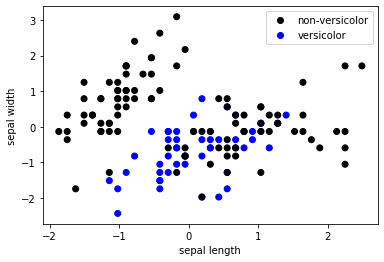

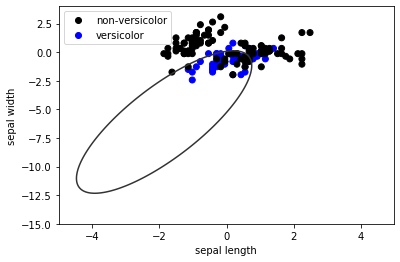

Polynomial Features
b0: 0.0726544754981003
x: 0.35850218964394714
y: -0.9848129078476522
xy: 0.7137778439392364
x**2: -1.0738109253084198
y**2: -0.18949010922496914
True Positive Rate: 0.7
False Positive Rate: 0.19
True Negative Rate: 0.81
False Negative Rate: 0.3
Overall Accuracy 0.7733333333333333


In [9]:
# Divide data into two classes.
Y_versi = (Y == 1).astype(np.int64)
classes_versi = ['non-versicolor', 'versicolor']
colors_versi = ListedColormap(['black', 'blue'])
# Plot the two-class division.
scatter = plt.scatter(X[:,0], X[:,1], c=Y_versi, cmap=colors_versi)
plt.legend(handles=scatter.legend_elements()[0], labels=classes_versi)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

# Add polynomial features.
Xpoly = np.concatenate((X[:,:2], (X[:,0]*X[:,1]).reshape(-1,1), 
                        X[:,:2]**2), axis=1)
# Model with regularization.
clf = LogisticRegressionCV(
    cv=5, 
    random_state=0).fit(Xpoly, Y_versi)
# Plot.
thresh = 0.50
scatter = plt.scatter(X[:,0], X[:,1], c=Y_versi, cmap=colors_versi)
plt.xlabel('sepal length')
plt.legend(handles=scatter.legend_elements()[0], labels=classes_versi)
plt.ylabel('sepal width')
xx, yy = np.mgrid[-5:5:.01, -15:15:.01]
grid = np.c_[xx.ravel(), yy.ravel(), (xx*yy).ravel(), 
             (xx**2).ravel(), (yy**2).ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plt.contour(xx, yy, probs, levels=[thresh], cmap="Greys", vmin=0, vmax=.6)
plt.ylim(-15, 4)
plt.show()
# Print parameters.
print("Polynomial Features")
print("b0:", clf.intercept_[0])
print("x:", clf.coef_[0,0])
print("y:", clf.coef_[0,1])
print("xy:", clf.coef_[0,2])
print("x**2:", clf.coef_[0,3])
print("y**2:", clf.coef_[0,4])
# Metrics.
print('True Positive Rate:', 
      np.sum(
          (clf.predict(Xpoly) >= thresh) * (Y_versi==1)
      ) / np.sum(Y_versi==1)
)
print('False Positive Rate:', 
      np.sum(
          (clf.predict(Xpoly) >= thresh) * (Y_versi==0)
      ) / np.sum(Y_versi==0)
)
print('True Negative Rate:', 
      np.sum(
          (clf.predict(Xpoly) < thresh) * (Y_versi==0)
      ) / np.sum(Y_versi==0)
)
print('False Negative Rate:', 
      np.sum(
          (clf.predict(Xpoly) < thresh) * (Y_versi==1)
      ) / np.sum(Y_versi==1)
)
print('Overall Accuracy', 
      (np.sum(
          (clf.predict(Xpoly) >= thresh) * (Y_versi==1)
      ) + \
      np.sum(
          (clf.predict(Xpoly) < thresh) * (Y_versi==0)
      )) / len(Y_versi)
)

# SVM

The plot of setosa vs. non-setosa shows the classes are linearly separable, or nearly so. Suppose we remove any points that cannot be linearly separated. A strategy for classification would be to draw a hyperplane between the classes that maximizes the perpendicular distance to the nearest point. This distance is known as a _margin_. The classifier would be a _maximal margin hyperplane_.

When the classes are not linearly separable, there is not a strict maximal margin hyperplane. To resolve this issue, we can draw a hyperplane which allows some points to be on the wrong side. The resulting classifier is called a _soft margin classifier_, and it is implemented in `sklearn` as follows.

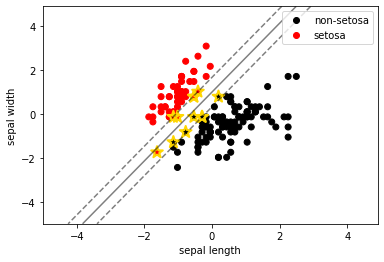

In [10]:
# Maximal soft margin hyperplane.
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X[:,:2], Y_setosa)
# Highlight suport vectors.
svs = clf.support_vectors_
scatter = plt.scatter(X[:,0], X[:,1], c=Y_setosa, cmap=colors_setosa)
plt.scatter(svs[:,0], svs[:,1], marker='*',
            facecolors='none', edgecolors='gold',
           s=150, linewidths=2)
plt.xlabel('sepal length')
plt.legend(handles=scatter.legend_elements()[0], labels=classes_setosa)
plt.ylabel('sepal width')
# Plot decision boundary and margins.
xx, yy = np.mgrid[-5:5:0.1, -5:5:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid).reshape(xx.shape)
plt.contour(
    xx, yy, Z, colors="k", 
    levels=[-1, 0, 1], alpha=0.5, 
    linestyles=["--", "-", "--"]
)
plt.show()

Note that in the above plot, the placement of the vectors outside the margins does not affect what the optimal hyperplane would be. The data vectors (points) within the margins do have influence. For this reason, they are called _support vectors_, and the model is called a _support vector classifier_.

The primal optimization problem being solved by the `sklearn` `SVC` with linear kernal is:

$$\text{minimize} \quad \frac{1}{2}\beta_{1:}^{T}\beta_{1:} + C \sum_{i=1}^{n} \epsilon_{i} \quad \text{subject to} \quad y_{i}(\beta_{1:}^{T}x_{i} + \beta_{0}) \geq 1 - \epsilon_{i};\ \epsilon_{i} \geq 0 \quad i=1, \ldots, n$$

$C$ is an inverse regularization strength parameter. Decreasing $C$ increases the allowance for data vectors to be misclassified. 

The primal problem has dual:

$$\text{minimize} \quad \frac{1}{2}\alpha^{T}Q\alpha - e^{T}\alpha \quad \text{subject to} \quad y^{T}\alpha = 0;\ 0 \leq \alpha_{i} \leq C \quad i=1, \ldots, n$$

where 

$$Q_{ij} = y_{i}y_{j} K(x_{i}, x_{j}); \quad K(x_{i}, x_{j}) = x_{i}^{T} x_{j}$$

The model can be used to fit a nonlinear decision boundary as well. One can project data which are not linearly separable into a higher-dimensional space in which they may be closer to linear separability. Here is an example:

![Shiyu Ji, distributed under a CC BY-SA 4.0 license](https://upload.wikimedia.org/wikipedia/commons/c/cc/Kernel_trick_idea.svg)

The linear classifier is fit in the higher-dimensional space and projected back down to produce a nonlinear decision boundary. Note that the higher-dimensional space may be abstract and impossible to directly visualize.

There is a powerful computational technique for fitting a support vector classifier with the above projection method. The technique is to generalize $K(x_{i}, x_{j})$ in the optimization problem to be 

$$K(x_{i}, x_{j}) = \phi(x_{i})^{T} \phi(x_{j})$$

where $\phi$ implicitly projects the data vectors to a higher-dimensional space. We may not be able to compute $\phi$, but we know it exists if $K(x_{i}, x_{j})$ satisfies certain conditions. $K(x_{i}, x_{j})$ is known as a _kernel_ function, and the technique of using kernels for implicit projection is called the _kernel trick_.

`sklearn` supports the following kernels:

- Linear: $x_{i}^{T}x_{j}$
- Polynomial: $(\gamma x_{i}^{T}x_{j} + r)^{d}$ (corresponds to mapping to a space of polynomial features)
- Radial Basis Function: $\exp\left(-\gamma \lVert x_{i} - x_{j} \rVert_{2}^{2}\right)$, $\gamma > 0$ (corresponds to mapping to infinite-dimensional space)
- Sigmoid: $\tanh (\gamma x_{i}^{T}x_{j} + r)$
- Custom

To each kernel is a corresponding linear decision function in the higher-dimensional space, which may be incalculable:

$$\beta_{1:}^{T}\phi(x) + \beta_{0}$$

This has an equivalent decision function in the lower-dimensional space, which can be calculated for appropriate kernel choices. This decision function depends only on support vectors in the set $SV$: 

$$\sum_{i \in SV} y_{i} \alpha_{i} K(x_{i}, x) + \beta_{0}$$

See how different kernels produce different decision boundaries by modifying the parameters of `svm.SVC` in the code below:

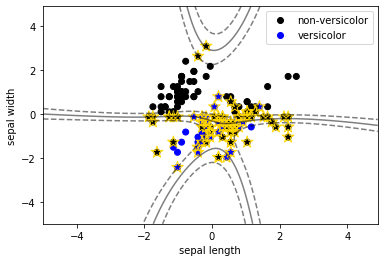

In [14]:
# Run with kernel={'linear', 'poly', 'rbf', 'sigmoid'}
clf = svm.SVC(kernel='sigmoid', C=1)
clf.fit(X[:,:2], Y_versi)
svs = clf.support_vectors_
# Plot.
scatter = plt.scatter(X[:,0], X[:,1], c=Y_versi, cmap=colors_versi)
plt.scatter(svs[:,0], svs[:,1], marker='*',
            facecolors='none', edgecolors='gold',
           s=150, linewidths=1)
plt.xlabel('sepal length')
plt.legend(handles=scatter.legend_elements()[0], labels=classes_versi)
plt.ylabel('sepal width')
xx, yy = np.mgrid[-5:5:0.1, -5:5:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(grid).reshape(xx.shape)
plt.contour(
    xx, yy, Z, colors="k", 
    levels=[-1, 0, 1], alpha=0.5, 
    linestyles=["--", "-", "--"]
)
plt.show()

Some last notes on SVM's:

- SVM's have the advantage of being able to fit flexible decision boundaries.
- SVM's have the disadvantage of being sensitive to the positioning of the support vectors. SVMs can be too flexible, leading to overfitting.
- The SVM classifier is binary, but SVMs can perform multiple classifcation through the one-vs-all or one-vs-rest strategy.
- Standardize features before building an SVM, because different scales result in different distances, which influences support vector calculations.
- There are SVM models for regression which are based on similar principles to the SV classifier. In SV regresion, one fits a curve rather than a decision boundary.